In [3]:
# Modules for debugging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend


# Custom modules
from preprocessing_post_fastsurfer.alignment import *
from preprocessing_post_fastsurfer.cropping import *
from preprocessing_post_fastsurfer.extraction import *
from preprocessing_post_fastsurfer.file_handling import *
from preprocessing_post_fastsurfer.mesh_creation import *
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *

# Custom modules
from ozzy_torch_utils.split_dataset import *
from ozzy_torch_utils.subject_dataset import *

np.set_printoptions(precision=2, suppress=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort"

selected_labels = ['CN', 'MCI']

# Dictionary key representing the disease labels
labels_string = 'research_group'

test_size = 0.3


In [5]:
dataset = SubjectDataset(data_path, selected_labels)

Csv files: ['/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort/idaSearch_3_19_2025.csv']


In [6]:

print(dataset[10]['volumes'])

print(dataset[10]['struct_names'])

[226.32  11.31   0.29  11.42  41.05   5.69   3.7    4.31   1.74   1.23
   1.13  17.41   3.18   1.21   0.9    0.54   3.18   0.56 227.63  11.91
   0.23  10.95  41.98   5.41   3.77   4.13   1.79   3.51   1.4    0.53
   3.1    0.59   1.78   0.     0.     0.     0.     0.     2.24   4.41
   3.39   1.48   6.21   8.68   8.65   1.84   7.71   6.44   3.91   3.71
   8.33   1.56   2.94   2.67   1.57   4.08   1.07   7.35   3.12   9.4
   7.55   3.02   9.39  18.56   8.19  11.01   8.19   0.74   4.95   1.58
   4.     2.74   1.28   6.02  10.88   8.87   1.78   8.21   6.39   4.14
   3.42   8.4    1.64   2.96   4.07   1.42   3.39   1.33   6.74   2.74
   9.32   7.96   1.8    9.91  20.5    8.67  10.41   7.36   0.63   5.19]
['Left-Cerebral-White-Matter' 'Left-Lateral-Ventricle' 'Left-Inf-Lat-Vent'
 'Left-Cerebellum-White-Matter' 'Left-Cerebellum-Cortex' 'Left-Thalamus'
 'Left-Caudate' 'Left-Putamen' 'Left-Pallidum' '3rd-Ventricle'
 '4th-Ventricle' 'Brain-Stem' 'Left-Hippocampus' 'Left-Amygdala' 'CSF'
 'Left-A

In [16]:
labels = np.array([dataset[index]['research_group'] for index in range(len(dataset.subject_list))])

volumes = np.array([dataset[index]['volumes'] for index in range(len(dataset.subject_list))])

print(f"Unique labels: {np.unique(labels, return_counts=True)}\n")

Unique labels: (array([0, 1]), array([195, 348]))



In [18]:

with parallel_backend('threading', n_jobs=8):

    model = GradientBoostingClassifier(n_estimators=4, learning_rate=0.1, max_depth=3)

    # Need to implement k fold with non-leakage datasets, there could be leakage here if single_img_per_subject is not selected
    cv = StratifiedKFold(n_splits=10, shuffle=True)

    cv_scores = cross_val_score(model, volumes, labels, cv=cv, scoring='accuracy')

    print(f'Cross-validation accuracy scores: {cv_scores}')
    print(f'Mean cross-validation accuracy: {np.mean(cv_scores)}')
    print(f'Standard deviation of cross-validation accuracy: {np.std(cv_scores)}')

Cross-validation accuracy scores: [0.64 0.65 0.64 0.61 0.67 0.65 0.65 0.63 0.59 0.61]
Mean cross-validation accuracy: 0.6334680134680134
Standard deviation of cross-validation accuracy: 0.021631889554923837


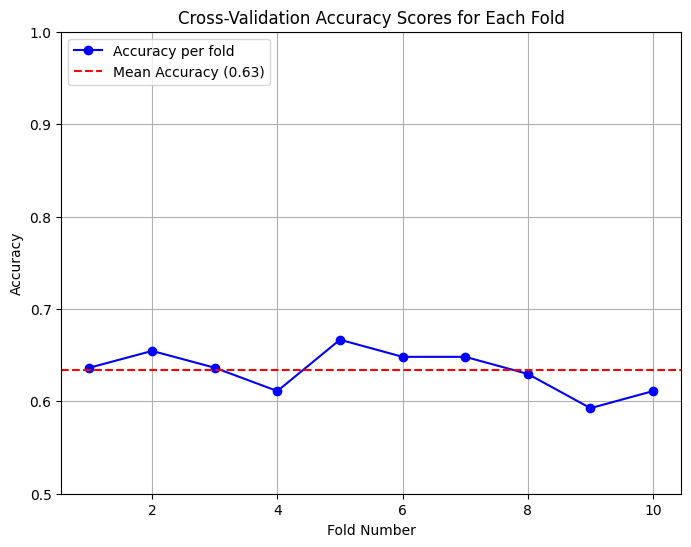

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='b', linestyle='-', label='Accuracy per fold')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean Accuracy ({np.mean(cv_scores):.2f})')
plt.title('Cross-Validation Accuracy Scores for Each Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

0.5624262969561185


<Axes: >

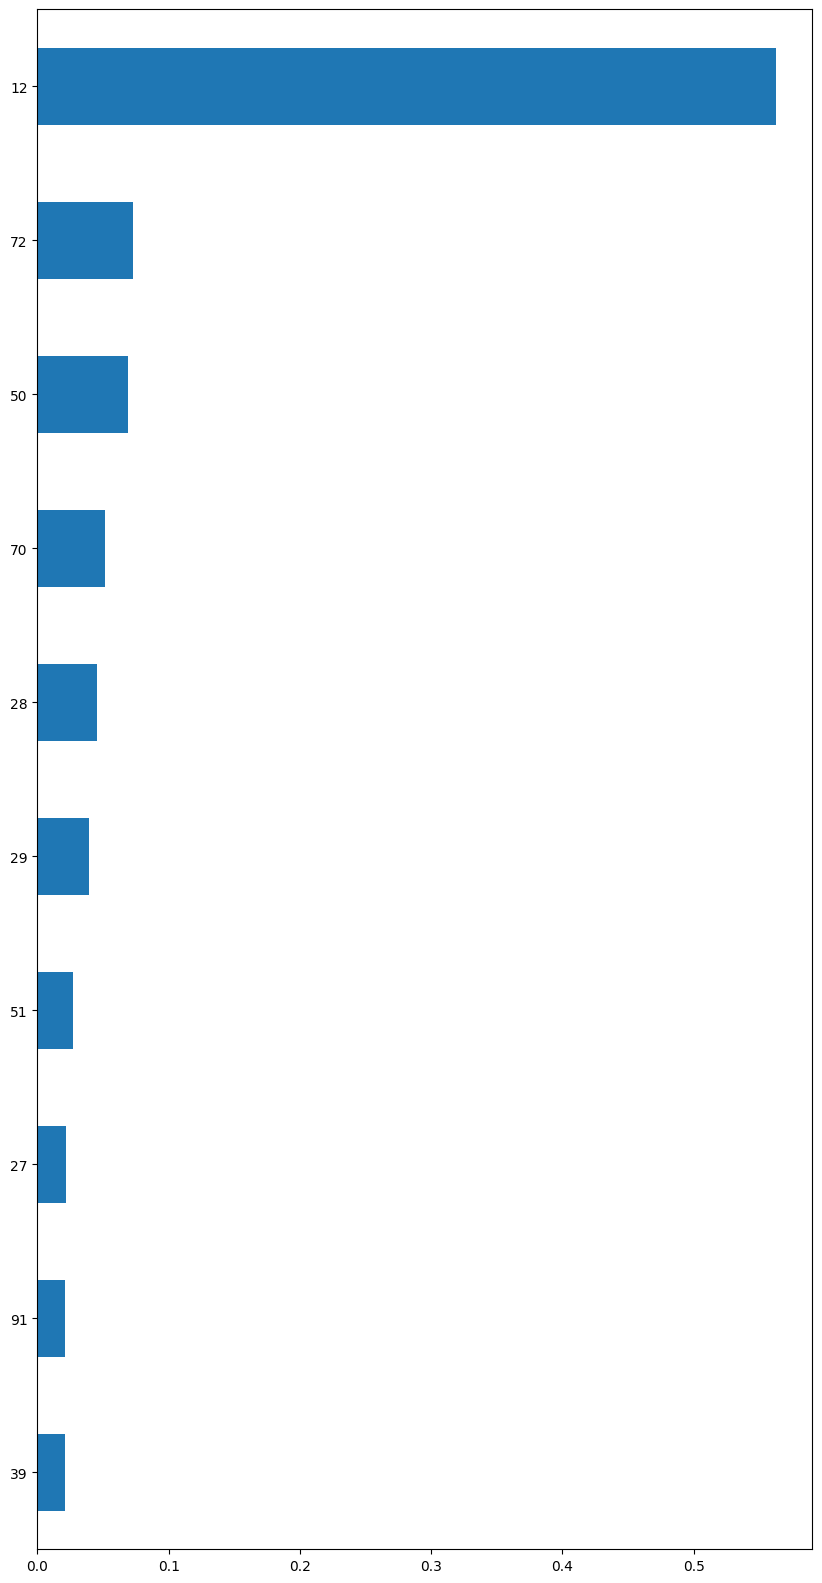

In [20]:

model.fit(volumes, labels)
feature_importance = pd.Series(model.feature_importances_)
print(max(feature_importance))
feature_importance.sort_values()[-10:].plot(kind="barh", figsize = (10, 20))

In [21]:

with parallel_backend('threading', n_jobs=8):

    model = HistGradientBoostingClassifier(learning_rate=0.1, max_leaf_nodes=10, max_depth=2, class_weight='balanced')

    # Need to implement k fold with non-leakage datasets, there could be leakage here if single_img_per_subject is not selected
    cv = StratifiedKFold(n_splits=10, shuffle=True)

    cv_scores = cross_val_score(model, volumes, labels, cv=cv, scoring='accuracy')

    print(f'Cross-validation accuracy scores: {cv_scores}')
    print(f'Mean cross-validation accuracy: {np.mean(cv_scores)}')
    print(f'Standard deviation of cross-validation accuracy: {np.std(cv_scores)}')

Cross-validation accuracy scores: [0.71 0.58 0.71 0.76 0.61 0.72 0.74 0.67 0.7  0.61]
Mean cross-validation accuracy: 0.6814814814814815
Standard deviation of cross-validation accuracy: 0.05770222588110803


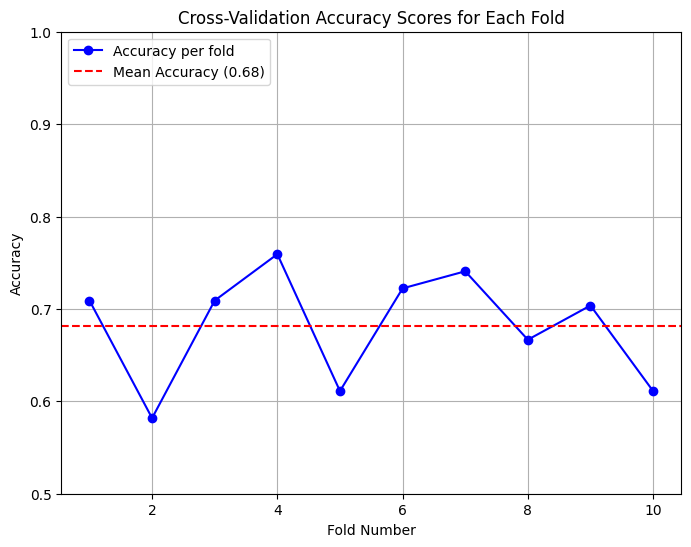

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='b', linestyle='-', label='Accuracy per fold')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean Accuracy ({np.mean(cv_scores):.2f})')
plt.title('Cross-Validation Accuracy Scores for Each Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [23]:
model = HistGradientBoostingClassifier(learning_rate=0.0001, max_iter=4, max_leaf_nodes=4, l2_regularization=4.0, min_samples_leaf=150, max_depth=2, class_weight='balanced', scoring='roc_auc')

model.fit(volumes, labels)

HistGradientBoostingClassifier(class_weight='balanced', l2_regularization=4.0,
                               learning_rate=0.0001, max_depth=2, max_iter=4,
                               max_leaf_nodes=4, min_samples_leaf=150,
                               scoring='roc_auc')

543


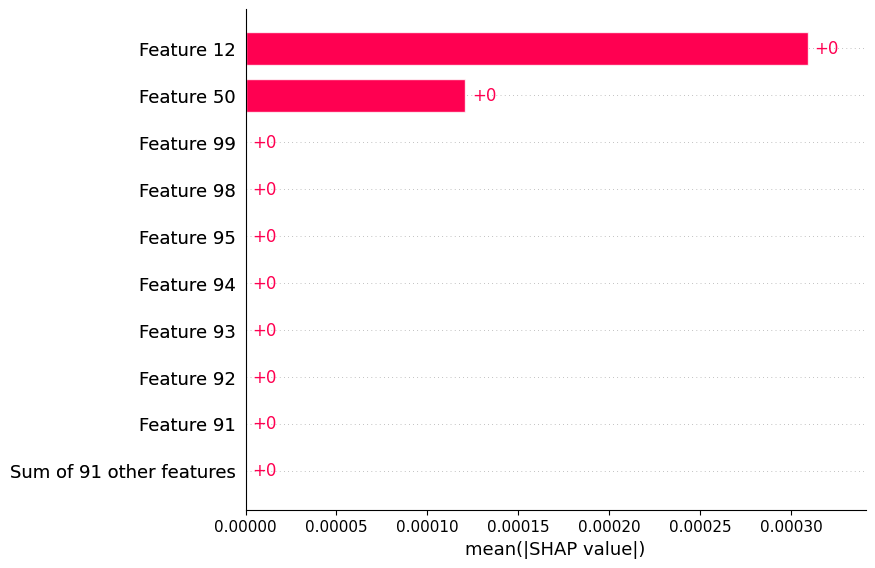

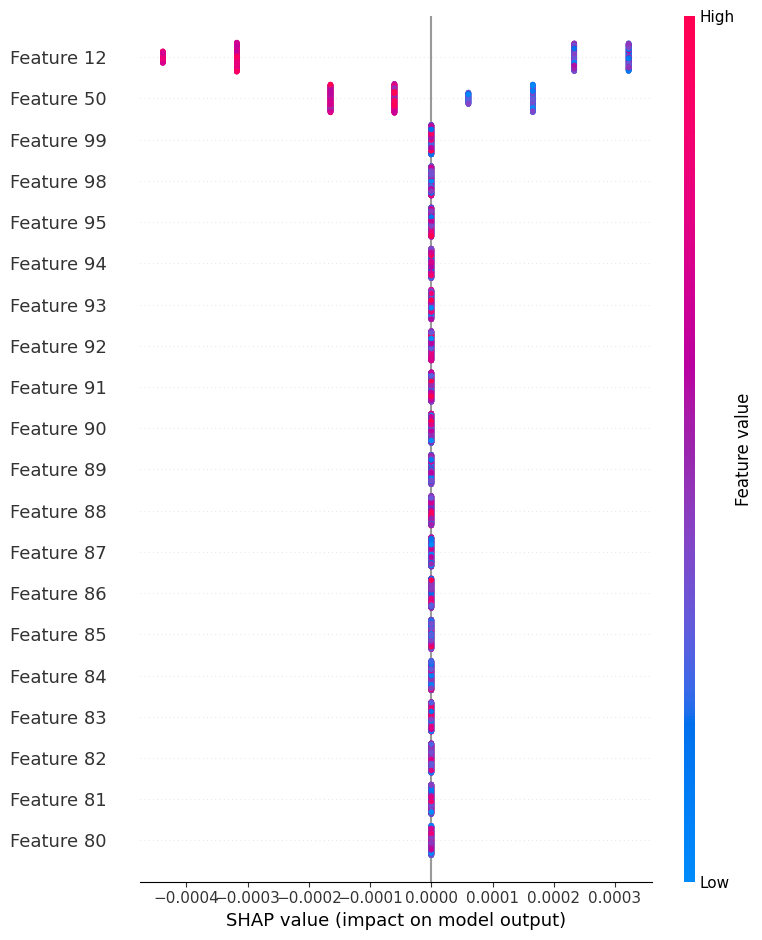

In [25]:
import shap

explainer = shap.Explainer(model)

sample = volumes # np.random.choice(scores.shape[0], 1, replace=False)

shap_values = explainer(sample)

print(len(shap_values))

shap.plots.bar(shap_values, max_display=10)

shap.summary_plot(shap_values, volumes)